# Final Project

The goal of this project is to correctly classify the outcomes of League of Legends matches. If you are not familiar with League of Legends, it is a popular video published by Riot Games Inc. The game is largely centered around team-play, where players engage in combat and taking objectives in order to win.

The data being used is taken from the Riot Games Rest-Api. This data is publicly available, although one will need an API key in order to do so. Using the API, I was able to use the Cassiopeia Framework (third party library) to query different endpoints for the needed data.

In [23]:
import random
from sortedcontainers import SortedList
import arrow

import cassiopeia as cass
from cassiopeia.core import Summoner, MatchHistory, Match
from cassiopeia import Season, Queue, Patch
from cassiopeia.core.match import ParticipantStatsData
from cassiopeia.datastores.riotapi.common import APIError

import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import patsy
import seaborn as sns
import sklearn.model_selection

import json 
import pprint
import math


DEV_KEY = "API KEY HERE"
cass.set_riot_api_key(DEV_KEY)


def filter_match_history(summoner, patch):
    end_time = patch.end
    if end_time is None:
        end_time = arrow.now()
    match_history = MatchHistory(summoner=summoner, queues={Queue.ranked_solo_fives}, begin_time=patch.start, end_time=end_time)
    return match_history


def collect_matches():
    initial_summoner_name = "sykotick"
    region = "NA"

    summoner = Summoner(name=initial_summoner_name, region=region)
    patch = Patch.from_str("10.6", region=region)
    unpulled_summoner_ids = SortedList([summoner.id])
    pulled_summoner_ids = SortedList()

    unpulled_match_ids = SortedList()
    pulled_match_ids = SortedList()
    count_matches = 0
    kills = []
    deaths = []
    gold = []
    kda = []
    win_stats = []
    loss_stats = []

    # while unpulled_summoner_ids:
    # Get a random summoner from our list of unpulled summoners and pull their match history
    while unpulled_summoner_ids:
        new_summoner_id = random.choice(unpulled_summoner_ids)
        new_summoner = Summoner(id=new_summoner_id, region=region)
        matches = filter_match_history(new_summoner, patch)
        unpulled_match_ids.update([match.id for match in matches])
        unpulled_summoner_ids.remove(new_summoner_id)
        pulled_summoner_ids.add(new_summoner_id)

        while unpulled_match_ids:
            # Get a random match from our list of matches
            new_match_id = random.choice(unpulled_match_ids)
            new_match = Match(id=new_match_id, region=region)

            win_kills = 0
            win_deaths = 0
            win_gold = 0
            win_dmg = 0
            win_tower_kills = 0
            win_assists = 0
            win_minions = 0
            win_barons = 0
            win_dragons = 0
            win_team_tower_kills = 0
            win_inhibs = 0
            win_first_tower = 0
            win_first_baron = 0
            win_vision_score = 0
            win_longest_time = 0
            win_dmg_to_obj = 0
            win_gold_deltas = 0
            win_xp_deltas = 0
            win_entries = []

            loss_kills = 0
            loss_deaths = 0
            loss_gold = 0
            loss_dmg = 0
            loss_assists = 0
            loss_tower_kills = 0
            loss_minions = 0
            loss_barons = 0
            loss_dragons = 0
            loss_team_tower_kills = 0
            loss_inhibs = 0
            loss_first_tower = 0
            loss_first_baron = 0
            loss_vision_score = 0
            loss_longest_time = 0
            loss_dmg_to_obj = 0
            loss_gold_deltas = 0
            loss_xp_deltas = 0
            loss_entries = []

            for participant in new_match.participants:
                # try:
                if (participant.stats.win):

                    ranks = []
                    for i in participant.summoner.ranks:
                        ranks.append(i)
                    try:
                        ix = ranks.index(Queue.ranked_solo_fives)
                        if len(ranks) > 0:
                            data = participant.summoner.league_entries[ix]
                            full_name = data.tier.name.upper() + " " + data.division.value
                            fives = {
                                "division": data.division.value, "tier": data.tier.name,
                                "wins": data.wins, "losses": data.losses, "full": full_name,
                                "mmr": True
                            }  
                    except:
                        if len(ranks) == 0:
                            fives = {
                                "division": None, "tier": None,
                                "wins": None, "losses": None,
                                "full": None, "mmr": False
                            }
                    win_entries.append(fives)
                    json_stats = participant.timeline.to_dict()
                    try:
                        win_gold_deltas += json_stats["goldPerMinDeltas"]["10-20"]
                        win_xp_deltas += json_stats["goldPerMinDeltas"]["0-10"]
                    except:
                        win_gold_deltas += 0
                        win_xp_deltas += 0
                        pass
                    win_kills += participant.stats.kills
                    win_deaths += participant.stats.deaths
                    win_gold += participant.stats.gold_earned
                    win_dmg += participant.stats.total_damage_dealt_to_champions
                    win_assists += participant.stats.assists
                    win_tower_kills += participant.stats.turret_kills
                    win_minions += participant.stats.total_minions_killed
                    win_barons += participant.team.baron_kills
                    win_dragons += participant.team.dragon_kills
                    win_team_tower_kills += participant.team.tower_kills
                    win_inhibs += participant.team.inhibitor_kills
                    win_first_tower += participant.team.first_tower
                    win_first_baron += participant.team.first_baron
                    win_vision_score += participant.stats.vision_score
                    win_longest_time += participant.stats.longest_time_spent_living
                    win_dmg_to_obj += (participant.stats.damage_dealt_to_objectives - participant.stats.damage_dealt_to_turrets)
                else:

                    ranks = []
                    for i in participant.summoner.ranks:
                        ranks.append(i)
                    try:
                        ix = ranks.index(Queue.ranked_solo_fives)
                        if len(ranks) > 0:
                            data = participant.summoner.league_entries[ix]
                            full_name = data.tier.name.upper() + " " + data.division.value
                            fives = {
                                "division": data.division.value, "tier": data.tier.name,
                                "wins": data.wins, "losses": data.losses, "full": full_name,
                                "mmr": True
                            }   
                    except:
                        if len(ranks) == 0:
                            fives = {
                                "division": None, "tier": None,
                                "wins": None, "losses": None,
                                "full": None, "mmr": False
                            }
                    loss_entries.append(fives)
                    json_stats = participant.timeline.to_dict()
                    try:
                        loss_gold_deltas += json_stats["goldPerMinDeltas"]["0-10"]
                        loss_xp_deltas += json_stats["goldPerMinDeltas"]["0-10"]
                    except:
                        loss_gold_deltas += 0
                        loss_xp_deltas += 0
                    loss_kills += participant.stats.kills
                    loss_deaths += participant.stats.deaths
                    loss_gold += participant.stats.gold_earned
                    loss_dmg += participant.stats.total_damage_dealt_to_champions
                    loss_assists += participant.stats.assists
                    loss_tower_kills += participant.stats.turret_kills
                    loss_minions += participant.stats.total_minions_killed
                    loss_barons += participant.team.baron_kills
                    loss_dragons += participant.team.dragon_kills
                    loss_team_tower_kills += participant.team.tower_kills
                    loss_inhibs += participant.team.inhibitor_kills
                    loss_first_tower += participant.team.first_tower
                    loss_first_baron += participant.team.first_baron
                    loss_vision_score += participant.stats.vision_score
                    loss_longest_time += participant.stats.longest_time_spent_living
                    loss_dmg_to_obj += (participant.stats.damage_dealt_to_objectives - participant.stats.damage_dealt_to_turrets)
               
                if participant.summoner.id not in pulled_summoner_ids and participant.summoner.id not in unpulled_summoner_ids:
                    unpulled_summoner_ids.add(participant.summoner.id)
                # except APIError:
                #     continue

            win_mmrs = mmr(win_entries)
            loss_mmrs = mmr(loss_entries)
            win_mmr_diff = (sum(win_mmrs)/len(win_mmrs)) - (sum(loss_mmrs)/len(loss_mmrs))
            loss_mmr_diff = ((sum(loss_mmrs)/len(loss_mmrs) - sum(win_mmrs)/len(win_mmrs)))

            win_gold_diff = win_gold - loss_gold
            loss_gold_diff = loss_gold - win_gold

            win_xp_diff = win_xp_deltas - loss_xp_deltas
            loss_xp_diff = loss_xp_deltas - win_xp_deltas

            win_dmg_diff = win_dmg - loss_dmg
            loss_dmg_diff = loss_dmg - win_dmg

            win_kills_diff = win_kills - loss_kills
            loss_kills_diff = loss_kills - win_kills

            if (win_deaths == 0):
                win_deaths += 1
            if (loss_deaths == 0):
                loss_deaths += 1
            win_kda_diff = ((win_kills + win_assists)/ win_deaths) - ((loss_kills + loss_assists)/ loss_deaths)
            loss_kda_diff = ((loss_kills + loss_assists)/ loss_deaths) - ((win_kills + win_assists)/ win_deaths)
            
            win_vision_score_diff = win_vision_score - loss_vision_score
            loss_vision_score_diff = loss_vision_score - win_vision_score

            win_stats.append([
                1, win_kills, win_deaths, win_assists, win_gold,
                win_dmg, win_tower_kills, win_minions, win_barons/5,
                win_dragons/5, win_team_tower_kills/5, win_inhibs/5,
                win_first_tower/5, win_first_baron/5, win_vision_score,
                win_longest_time, win_dmg_to_obj, win_gold_deltas, win_xp_deltas,
                win_mmr_diff, win_gold_diff, win_xp_diff, win_dmg_diff,
                win_kills_diff, win_kda_diff, win_vision_score_diff
                ])
            loss_stats.append([
                0, loss_kills, loss_deaths, loss_assists, loss_gold,
                loss_dmg, loss_tower_kills, loss_minions, loss_barons/5,
                loss_dragons/5, loss_team_tower_kills/5, loss_inhibs/5,
                loss_first_tower/5, loss_first_baron/5, loss_vision_score,
                loss_longest_time, loss_dmg_to_obj, loss_gold_deltas, loss_xp_deltas,
                loss_mmr_diff, loss_gold_diff, loss_xp_diff, loss_dmg_diff,
                loss_kills_diff, loss_kda_diff, loss_vision_score_diff
            ])

            # The above lines will trigger the match to load its data by iterating over all the participants.
            # If you have a database in your datapipeline, the match will automatically be stored in it.
            unpulled_match_ids.remove(new_match_id)
            pulled_match_ids.add(new_match_id)
            if len(pulled_match_ids) >= 500:
                break
        else:
            continue
        break
    cols = [
        "win", "kills", "deaths", "assists", "gold", "dmg", "tower",
        "minions", "barons", "dragons", "ttk", "tik", "ft", "fb",
        "vision", "ltspl", "dto", "g_delt", "xp_delt", "mmr", "gold_diff", "xp_diff",
        "dmg_diff", "kills_diff", "kda_diff", "vision_score_diff"
        ] 
    wins = pd.DataFrame(win_stats, columns=cols)
    losses = pd.DataFrame(loss_stats, columns=cols)
    wins.to_csv('wins_diff_2.csv', index=False)
    losses.to_csv('losses_diff_2.csv', index=False)


def mmr(team_entries):
    indices = []
    mmrs = []
    avgs = []
    for i in team_entries:
        if i["full"] != None:
            val = calculate_mmr(i)
            mmrs.append(val)
            avgs.append(val)
        else:
            mmrs.append(0)

    length = len(avgs)
    if len(avgs) == 0:
        length = 1

    avg = sum(avgs)/length
    for i in range(len(mmrs)):
        if mmrs[i] == 0:
            mmrs[i] = avg
    return(mmrs)

    
def calculate_mmr(data):
    leagues = {
        "IRON V" :480,
        "IRON IV" :540,
        "IRON III" :600,
        "IRON II" :660,
        "IRON I" :720,
        "BRONZE V" :780,
        "BRONZE IV": 840,
        "BRONZE III": 900,
        "BRONZE II": 960,
        "BRONZE I": 1020,
        "SILVER V" :1090,
        "SILVER IV": 1150,
        "SILVER III": 1210,
        "SILVER II": 1280,
        "SILVER I": 1350,
        "GOLD V" :1410,
        "GOLD IV": 1480,
        "GOLD III": 1540,
        "GOLD II": 1600,
        "GOLD I": 1660,
        "PLATINUM V" :1720,
        "PLATINUM IV": 1780,
        "PLATINUM III": 1840,
        "PLATINUM II": 1900,
        "PLATINUM I": 1960,
        "DIAMOND V" :2030,
        "DIAMOND IV": 2100,
        "DIAMOND III": 2160,
        "DIAMOND II": 2230,
        "DIAMOND I": 2270,
        "MASTER I": 2330,
        "GRANDMASTER I": 2500,
        "CHALLENGER I": 2700
    }
    if (data["full"]):
        wins = data["wins"]
        losses = data["losses"]
        totalGames = data["wins"] + data["losses"]
        if wins == 0 or wins == None:
            totalGames += 1
            wins += 1
        winningPercentage = (wins / totalGames) * 100;
        eloDiff = -400 * np.log(1 / (wins / totalGames ) - 1)/ 2.30258509299
        return np.round(((leagues[data["full"]] + eloDiff)))
    else:
        wins = data["wins"]
        losses = data["losses"]
        totalGames = data["wins"] + data["losses"]
        if wins == 0 or wins == None:
            totalGames += 1
            wins += 1
        winningPercentage = (data["wins"] / totalGames) * 100;
        eloDiff = -400 * np.log(1 / ((data["wins"] / totalGames ) - 1))/ 2.30258509299
        return np.round(((leagues[data["full"]] + eloDiff)))

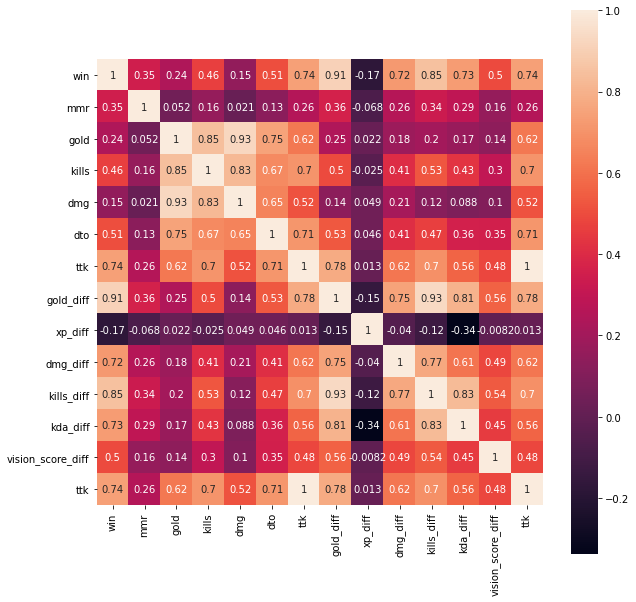

In [24]:
wins = pd.read_csv('wins_diff.csv')
losses = pd.read_csv('losses_diff.csv')
wins_2 = pd.read_csv('wins_diff_2.csv')
losses_2 = pd.read_csv('losses_diff_2.csv')

wins = wins.iloc[::2] #even rows only for wins
losses = losses.iloc[1::2] #odd rows only for losses -> keeps wins and losses as independent events
wins_2 = wins_2.iloc[::2] #even rows only for wins
losses_2 = losses_2.iloc[1::2] #odd rows only for losses -> keeps wins and losses as independent events

result = pd.concat([wins, wins_2, losses, losses_2])
cols = [
    "win", "mmr", "gold", "kills", "dmg",
    "dto", "ttk", "gold_diff", "xp_diff", "dmg_diff",
    "kills_diff", "kda_diff", "vision_score_diff", "ttk"
    ]
fig = plt.figure(figsize=(10,10))
sns.heatmap(result[cols].corr(),annot=True,square=True)
plt.show()

In [30]:
ilr = LogisticRegression(random_state=0, solver="saga", max_iter=4000, tol=.01)
y, X = patsy.dmatrices("win ~ kills_diff + gold_diff + dmg_diff + ttk", data=result)

iX_train, iX_test, iy_train, iy_test = sklearn.model_selection.train_test_split(
    X, y, test_size = 0.3, random_state = 0
)

win_loss_mod = ilr.fit(iX_train, iy_train.ravel())
print("Training Score: ", win_loss_mod.score(iX_train, iy_train.ravel()))
print("Testing Score is ", win_loss_mod.score(iX_test, iy_test.ravel()))

predictions = ilr.predict(iX_test)
print(confusion_matrix(iy_test.ravel(), predictions))

Training Score:  0.98
Testing Score is  0.98
[[154   2]
 [  4 140]]


In [32]:
import sklearn.neighbors as neighbors

clf = neighbors.KNeighborsClassifier(n_neighbors=1, weights="uniform", n_jobs=-1)
clf.fit(iX_train, iy_train.ravel())
predictions = clf.predict(iX_test)
results = clf.score(iX_train, iy_train.ravel())
print(results)
results = clf.score(iX_test, iy_test)
print(results)
confusion_matrix(iy_test.ravel(), predictions)


1.0
0.986666666667


array([[154,   2],
       [  2, 142]])

In [21]:
from sklearn.preprocessing import StandardScaler
# Separating out the features
cols = [
        "kills", "deaths", "assists", "gold", "dmg", "tower",
        "minions", "barons", "dragons", "ttk", "tik", "ft", "fb",
        "vision", "ltspl", "dto", "g_delt", "xp_delt", "mmr", "gold_diff", "xp_diff",
        "dmg_diff", "kills_diff", "kda_diff", "vision_score_diff"
        ] 
x = result.loc[:, cols].values
x = StandardScaler().fit_transform(x)

In [22]:
from factor_analyzer import FactorAnalyzer
n_factors = 5
fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")
fa.fit(x)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([  1.06418135e+01,   4.93688990e+00,   1.88807256e+00,
         1.22563997e+00,   1.00526454e+00,   8.25591012e-01,
         7.62121920e-01,   6.74097710e-01,   6.00543157e-01,
         4.94978505e-01,   4.06289032e-01,   3.83817291e-01,
         2.66352097e-01,   1.75299966e-01,   1.55311264e-01,
         1.35819622e-01,   1.17777349e-01,   8.67470222e-02,
         7.29045284e-02,   5.37272159e-02,   4.21428456e-02,
         2.99471592e-02,   9.94514994e-03,   8.66424515e-03,
         2.42425404e-04])

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=5, rotation='varimax',
               rotation_kwargs={}, use_smc=True)


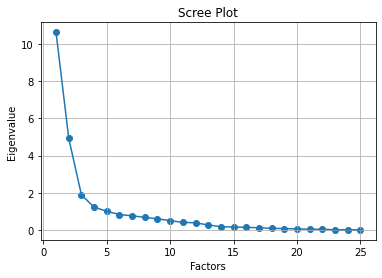

In [6]:
print(fa)
plt.scatter(range(1, x.shape[1]+1),ev)
plt.plot(range(1, x.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()
df = pd.DataFrame(fa.loadings_, columns=[str(i+1) for i in range(fa.n_factors)], index=cols)

In [7]:
print(fa.get_factor_variance()[2])
df

[ 0.27051404  0.44245779  0.56455419  0.65569079  0.7462354 ]


,1,2,3,4,5
kills,0.443740,0.345543,0.772268,0.105310,0.161841
deaths,-0.609305,0.366903,0.636923,0.115349,0.019903
assists,0.326441,0.408381,0.677846,0.098596,0.247652
gold,0.156747,0.730950,0.611716,0.113604,0.230627
dmg,0.072167,0.577591,0.729151,0.092814,0.194438
tower,0.769014,0.332926,0.264178,0.162539,0.222707
minions,-0.071186,0.882984,0.274085,0.087070,0.121535
barons,0.208820,0.261421,0.197595,0.088559,0.918168
dragons,0.531605,0.444767,0.242351,0.090809,0.183509
ttk,0.766314,0.344857,0.283091,0.174681,0.223194
